In [1]:
%matplotlib inline

In [222]:
!pip install torchmetrics

Translation with a Sequence to Sequence Network
*************************************************************

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



In [224]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip -o fra-eng.zip
!mkdir data
!mv fra.txt data/eng-fra.txt

--2024-04-12 22:17:24--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: 'fra-eng.zip.5'

fra-eng.zip.5       100%[===================>]   7.57M  20.6MB/s    in 0.4s    

2024-04-12 22:17:24 (20.6 MB/s) - 'fra-eng.zip.5' saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
mkdir: cannot create directory 'data': File exists


In [225]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [226]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [227]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [228]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [229]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
#print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 22907 sentence pairs
Counting words...
Counted words:
fra 7019
eng 4638


In [230]:
from sklearn.model_selection import train_test_split

In [231]:
X = [i[0] for i in pairs]
y = [i[1] for i in pairs]

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [233]:
train_pairs = list(zip(X_train,y_train))
test_pairs = list(zip(X_test,y_test))

In [234]:
import matplotlib.pyplot as plt
import numpy as np

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.






In [167]:
# # ####################
# # #Task 2 and 5 Encoder
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)

#     def forward(self, input, hidden):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)
    
#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

In [105]:
# #### LSTM ##### 
# #Task 3
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)

#     def forward(self, input, hidden, cell):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) # [input_size, batch_size, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
#         return output, (hidden, cell)

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

In [140]:
# #### bi-LSTM ##### 
# # Task 4

# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)

#     def forward(self, input, hidden, cell):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded # [input_size, batch_size, 2*hidden_size]
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) 
#         return output, (hidden, cell) # [input_size, batch_size, 2*hidden_size], ([2, batch_size, hidden_size], [2, batch_size, hidden_size])

#     def initHidden(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

In [249]:
##### bi-LSTM ##### 
# Task 6
from torch import Tensor
class PositionalEncoding(nn.Module):

    def __init__(self, input_size, dropout=0.1, max_len=MAX_LENGTH):
        super().__init__()
        # self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2) * (-math.log(10000.0) / input_size))
        pe = torch.zeros(max_len, 1, input_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        # return self.dropout(x)
        return x

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        self.tel = nn.TransformerEncoderLayer(hidden_size, nhead=2, dim_feedforward=hidden_size)
        self.te = nn.TransformerEncoder(self.tel, num_layers=2)
        # initial nhead=2, num_layers=2
        # 2nd: nhead=4, num_layers=12


    def forward(self, input):
        embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
        output = embedded
        # output, hidden = self.gru(output, hidden)
        output = self.pos_encoder(output)
        output = self.te(output)

        return output # [1, batch_size, hidden_size]

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



The Decoder (Your assignment)
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).


In [250]:
######### The original decoder - The best
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)

#     def forward(self, input, hidden):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

In [251]:
##### Original ##### Task 2 & 6

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [252]:
# ##### LSTM ##### Task 3

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden, cell):

#         # Your code here #
#         output = self.embedding(input).view(1, 1, -1)
#         output = F.relu(output)
#         output, (hidden, cell) = self.lstm(output, (hidden, cell)) # [input_size, batch_size, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
#         output = self.softmax(self.out(output[0]))
#         return output, (hidden, cell)

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

In [253]:
##### bi-LSTM ##### Task 4

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(output_size, 2*hidden_size)
#         self.gru = nn.GRU(2*hidden_size, 2*hidden_size)
#         self.out = nn.Linear(2*hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):

#         # Your code here #
#         output = self.embedding(input).view(1, 1, -1) # [1, batch_size, 2*hidden_size]
#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden) # [input_size, batch_size, 2*hidden_size], [2, batch_size, hidden_size]
#         output = self.softmax(self.out(output[0]))
#         return output, hidden # [input_size, batch_size, 2*hidden_size], [2, batch_size, hidden_size]

#     def initHidden(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(2, 1, self.hidden_size, device=device)

In [254]:
# # ##### Attention ##### Task 5

# class Decoder(nn.Module):
#     def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         # self.dropout_p = dropout_p
#         self.max_length = max_length

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
#         self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         # self.dropout = nn.Dropout(self.dropout_p)
#         self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)

#     def forward(self, input, hidden, encoder_hiddens):
#       # hidden = [1, batch_size, hidden_size]
#       # encoder_hiddens = [max_length, hidden_size]
#         embedded = self.embedding(input).view(1, 1, -1) # [1, batch_size, hidden_size]
#         # embedded = self.dropout(embedded) # [1, batch_size, hidden_size]

#         attn_scores = torch.mm(hidden[0], torch.transpose(encoder_hiddens, 0, 1)) # [batch_size, max_length]
#         attn_distribution = F.softmax(attn_scores, dim=1) # [batch_size, max_length]
#         attn_outputs = torch.mm(attn_distribution, encoder_hiddens) # [batch_size, hidden_size]
#         attn_outputs = attn_outputs.unsqueeze(0) # [1, batch_size, hidden_size]

#         output = torch.cat((embedded[0], attn_outputs[0]), 1) # [batch_size, 2*hidden_size]
#         output = self.attn_combine(output).unsqueeze(0) # [1, batch_size, hidden_size]

#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)

#         output = F.log_softmax(self.out(output[0]), dim=1)
#         return output, hidden, attn_distribution

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

#     def initCell(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)

# Transformer Encoder/Decoder

In [255]:
#### Task 6
class PositionalEncoding(nn.Module):

    def __init__(self, input_size, dropout=0.1, max_len=MAX_LENGTH):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2) * (-math.log(10000.0) / input_size))
        pe = torch.zeros(max_len, 1, input_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [256]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [80]:
# ################ Original - The Best
# teacher_forcing_ratio = 0.5

# def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
#     encoder_hidden = encoder.initHidden()

#     encoder_optimizer.zero_grad()
#     decoder_optimizer.zero_grad()

#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#     loss = 0

#     for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(
#             input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]

#     decoder_input = torch.tensor([[SOS_token]], device=device)

#     decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             loss += criterion(decoder_output, target_tensor[di])
#             decoder_input = target_tensor[di]  # Teacher forcing

#     else:
#         # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break

#     loss.backward()

#     encoder_optimizer.step()
#     decoder_optimizer.step()

#     return loss.item() / target_length

In [257]:
#- Copied code
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCell()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
#     encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device) ##### bi-LSTM ##### Task 4
#     encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device) ##### Attention ##### Task 5

    loss = 0

    for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) ##### Original ##### Task 2 & 5
#         encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell) #### LSTM ##### Task 3
#         encoder_output, (encoder_hidden, encoder_cell)  = encoder(input_tensor[ei], encoder_hidden, encoder_cell) #### LSTM ##### Task 4
        encoder_output = encoder(input_tensor[ei]) ##### Transformer ##### Task 6

        encoder_outputs[ei] = encoder_output[0, 0]
#         encoder_hiddens[ei] = encoder_hidden[0, 0] ##### Attention ##### Task 5

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
#     decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2])) ##### bi-LSTM ##### Task 4
#     decoder_cell = encoder_cell ##### LSTM ##### Task 3
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
#             decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### LSTM ##### Task 4
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
#             decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### bi-LSTM ##### Task 4
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length


This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [258]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [259]:
def trainIters(encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    iter = 1
    n_iters = len(train_pairs) * epochs

    for epoch in range(epochs):
        print("Epoch: %d/%d" % (epoch, epochs))
        for training_pair in train_pairs:
            training_pair = tensorsFromPair(training_pair)

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))
            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

            iter += 1

    # Plot training Curves
    plt.figure(figsize=(12, 6))  # Adjust the figure size
    plt.plot(plot_losses,linestyle='-')  # Use markers and solid lines
    plt.ylim(0, max(plot_losses) * 1.1)  # Add some padding to the y-axis limit
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.grid(True)  # Add gridlines for better readability
    plt.title('Training Loss Curve')  # Add a title to the plot
    plt.show()  # Show the plot
    return plot_losses

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [111]:
########## The Orginal - The Best
# def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

#         decoder_hidden = encoder_hidden

#         decoded_words = []

#         for di in range(max_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token:
#                 decoded_words.append('<EOS>')
#                 break
#             else:
#                 decoded_words.append(output_lang.index2word[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return decoded_words

In [120]:
# def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()
#         encoder_cell = encoder.initCell()  # Initialize cell state

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[SOS_token]], device=device)
#         decoder_hidden = encoder_hidden
#         decoder_cell = encoder_cell  # Pass the cell state to the decoder

#         decoded_words = []

#         for di in range(max_length):
#             decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell)
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token:
#                 decoded_words.append('')
#                 break
#             else:
#                 decoded_words.append(output_lang.index2word[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return decoded_words

In [218]:
# # Task 5
# PAD_token = 0  # Define PAD_token if not already defined

# def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()
#         encoder_cell = encoder.initCell()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
#         encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#             encoder_outputs[ei] = encoder_output[0, 0]
#             encoder_hiddens[ei] = encoder_hidden[0, 0]

#         decoder_input = torch.tensor([[SOS_token]], device=device)
#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens)
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token:
#                 decoded_words.append('<EOS>')
#                 break
#             elif topi.item() != PAD_token:
#                 decoded_words.append(output_lang.index2word[topi.item()])
#             decoder_input = topi.squeeze().detach()

#         # Join the list of words into a single string
#         output_sentence = ' '.join(decoded_words).strip()
#         return output_sentence

In [260]:
#Copied 
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initCell()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
#         encoder_outputs = torch.zeros(max_length, 2*encoder.hidden_size, device=device) ##### bi-LSTM ##### Task 4
#         encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device) ##### Attention ##### Task 5

        for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) ##### Original ##### Task 2 & 5
#             encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell) ##### LSTM ##### Task 3
#             encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell) ##### bi-LSTM ##### Task 4
            encoder_output = encoder(input_tensor[ei]) ##### Transformer ##### Task 6

            encoder_outputs[ei] += encoder_output[0, 0]
#             encoder_hiddens[ei] = encoder_hidden[0, 0] ##### Attention ##### Task 5

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
#         decoder_hidden = torch.reshape(decoder_hidden, (1,1,2*decoder_hidden.shape[2])) ##### bi-LSTM ##### Task 4
#         decoder_cell = encoder_cell ##### LSTM ##### Task 3

        decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length) ##### Attention ##### Task 5

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### Original ##### Task 2 & 6
#             decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell) ##### LSTM ##### Task 3
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) ##### bi-LSTM ##### Task 4
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hiddens) ##### Attention ##### Task 5

#             decoder_attentions[di] = decoder_attention.data ##### Attention ##### Task 5
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words
#         return decoded_words, decoder_attentions[:di + 1] ##### Attention ##### Task 5

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [261]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [267]:
from torchmetrics.text.rouge import ROUGEScore
from tqdm import tqdm
import numpy as np

rouge = ROUGEScore()

def test(encoder, decoder, testing_pairs):
    input = []
    gt = []
    predict = []
    metric_score = {
        "rouge1_fmeasure":[],
        "rouge1_precision":[],
        "rouge1_recall":[],
        "rouge2_fmeasure":[],
        "rouge2_precision":[],
        "rouge2_recall":[]
    }

    for i in tqdm(range(len(testing_pairs))):
        pair = testing_pairs[i]
        output_words = evaluate(encoder, decoder, pair[0]) # enable this after task 5
#         output_words, attentions = evaluate(encoder, decoder, pair[0]) ##### Attention ##### Task 5
        output_sentence = ' '.join(output_words)

        input.append(pair[0])
        gt.append(pair[1])
        predict.append(output_sentence)

        try:
            rs = rouge(output_sentence, pair[1])
        except:
            continue
        metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
        metric_score["rouge1_precision"].append(rs['rouge1_precision'])
        metric_score["rouge1_recall"].append(rs['rouge1_recall'])
        metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
        metric_score["rouge2_precision"].append(rs['rouge2_precision'])
        metric_score["rouge2_recall"].append(rs['rouge2_recall'])
        
    metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
    metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
    metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
    metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
    metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
    metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

    print("=== Evaluation score - Rouge score ===")
    print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
    print("Rouge1 precision:\t",metric_score["rouge1_precision"])
    print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
    print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
    print("Rouge2 precision:\t",metric_score["rouge2_precision"])
    print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
    print("=====================================")
    return input,gt,predict,metric_score

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




### Task 2 Losses

Epoch: 0/5
0m 59s (- 19m 19s) (5000 4%) 3.2582
1m 59s (- 18m 33s) (10000 9%) 2.6493
3m 0s (- 17m 38s) (15000 14%) 2.3379
4m 1s (- 16m 42s) (20000 19%) 2.1360
Epoch: 1/5
5m 2s (- 15m 45s) (25000 24%) 1.9498
6m 3s (- 14m 45s) (30000 29%) 1.7541
7m 4s (- 13m 46s) (35000 33%) 1.5888
8m 6s (- 12m 46s) (40000 38%) 1.5020
Epoch: 2/5
9m 7s (- 11m 47s) (45000 43%) 1.3891
10m 9s (- 10m 47s) (50000 48%) 1.2768
11m 11s (- 9m 47s) (55000 53%) 1.1792
12m 13s (- 8m 46s) (60000 58%) 1.1042
Epoch: 3/5
13m 15s (- 7m 45s) (65000 63%) 1.0492
14m 16s (- 6m 44s) (70000 67%) 0.9785
15m 18s (- 5m 43s) (75000 72%) 0.9090
16m 20s (- 4m 42s) (80000 77%) 0.8486
Epoch: 4/5
17m 22s (- 3m 41s) (85000 82%) 0.8025
18m 24s (- 2m 40s) (90000 87%) 0.7616
19m 26s (- 1m 39s) (95000 92%) 0.7177
20m 27s (- 0m 37s) (100000 97%) 0.6745


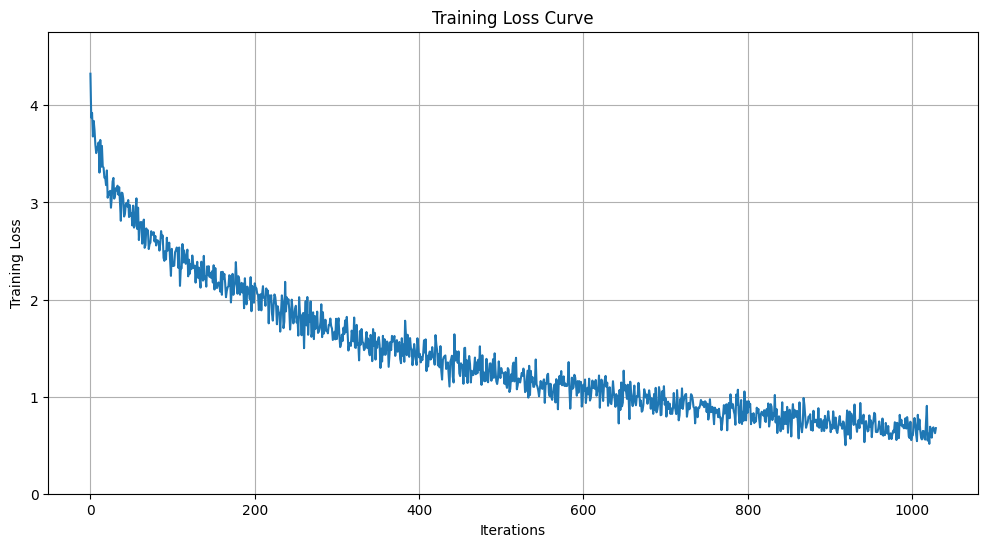

In [49]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task_2_losses = trainIters(encoder1, decoder1, 5, print_every=5000)

### Task 3 Losses

Epoch: 0/5
1m 5s (- 21m 22s) (5000 4%) 3.3937
2m 13s (- 20m 39s) (10000 9%) 2.9307
3m 21s (- 19m 40s) (15000 14%) 2.6754
4m 29s (- 18m 38s) (20000 19%) 2.4775
Epoch: 1/5
5m 37s (- 17m 35s) (25000 24%) 2.2916
6m 46s (- 16m 29s) (30000 29%) 2.1293
7m 54s (- 15m 23s) (35000 33%) 1.9792
9m 3s (- 14m 16s) (40000 38%) 1.8885
Epoch: 2/5
10m 12s (- 13m 10s) (45000 43%) 1.7729
11m 21s (- 12m 3s) (50000 48%) 1.6752
12m 30s (- 10m 55s) (55000 53%) 1.5767
13m 38s (- 9m 47s) (60000 58%) 1.5099
Epoch: 3/5
14m 47s (- 8m 40s) (65000 63%) 1.4282
15m 56s (- 7m 32s) (70000 67%) 1.3519
17m 5s (- 6m 23s) (75000 72%) 1.2825
18m 14s (- 5m 15s) (80000 77%) 1.2129
Epoch: 4/5
19m 23s (- 4m 7s) (85000 82%) 1.1553
20m 32s (- 2m 59s) (90000 87%) 1.0961
21m 40s (- 1m 50s) (95000 92%) 1.0367
22m 50s (- 0m 42s) (100000 97%) 0.9734


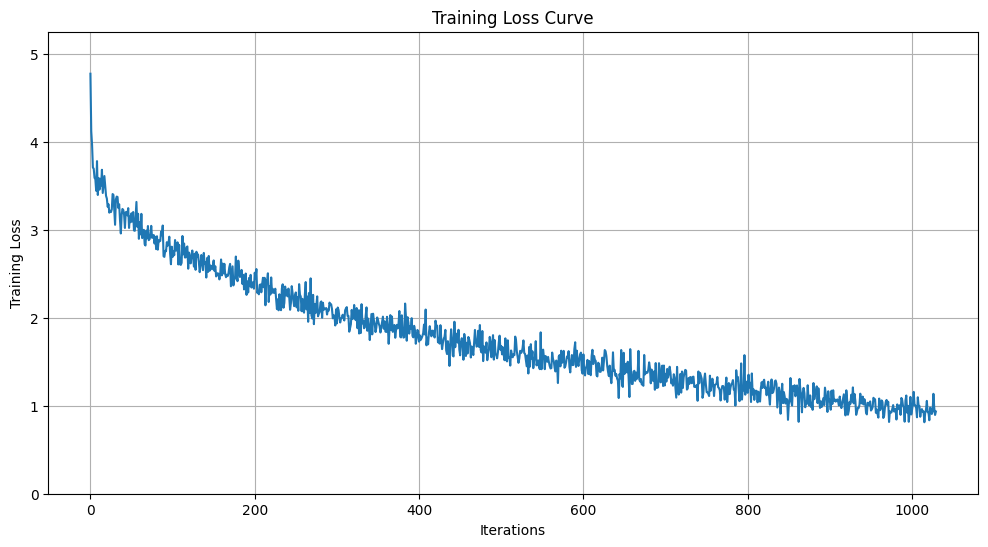

In [115]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task_3_losses = trainIters(encoder1, decoder1, 5, print_every=5000)

## Task 4 Losses

Epoch: 0/5
1m 31s (- 29m 48s) (5000 4%) 3.3711
3m 3s (- 28m 31s) (10000 9%) 2.7679
4m 37s (- 27m 9s) (15000 14%) 2.4374
6m 12s (- 25m 46s) (20000 19%) 2.2241
Epoch: 1/5
7m 46s (- 24m 18s) (25000 24%) 2.0169
9m 22s (- 22m 49s) (30000 29%) 1.8183
10m 57s (- 21m 18s) (35000 33%) 1.6636
12m 32s (- 19m 46s) (40000 38%) 1.5493
Epoch: 2/5
14m 7s (- 18m 13s) (45000 43%) 1.4454
15m 42s (- 16m 40s) (50000 48%) 1.3511
17m 17s (- 15m 7s) (55000 53%) 1.2177
18m 53s (- 13m 33s) (60000 58%) 1.1524
Epoch: 3/5
20m 29s (- 12m 0s) (65000 63%) 1.0994
22m 4s (- 10m 25s) (70000 67%) 1.0080
23m 40s (- 8m 51s) (75000 72%) 0.9485
25m 15s (- 7m 17s) (80000 77%) 0.8668
Epoch: 4/5
26m 52s (- 5m 42s) (85000 82%) 0.8365
28m 27s (- 4m 8s) (90000 87%) 0.7932
30m 3s (- 2m 33s) (95000 92%) 0.7448
31m 39s (- 0m 58s) (100000 97%) 0.6901


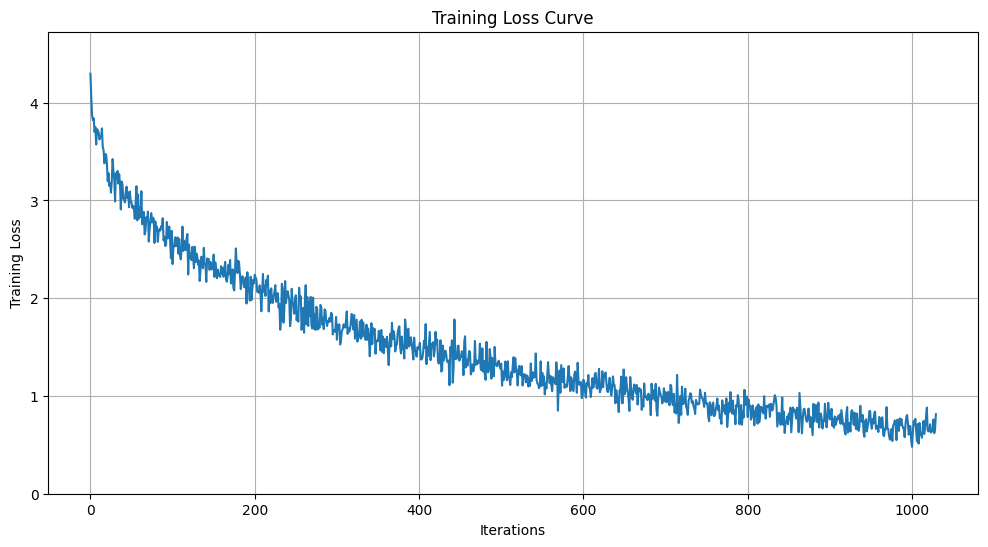

In [151]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task_4_losses = trainIters(encoder1, decoder1, 5, print_every=5000)

## Task 5 Loses

Epoch: 0/5
1m 29s (- 29m 20s) (5000 4%) 3.2342
3m 1s (- 28m 10s) (10000 9%) 2.6524
4m 35s (- 26m 59s) (15000 14%) 2.3501
6m 9s (- 25m 34s) (20000 19%) 2.1541
Epoch: 1/5
7m 42s (- 24m 4s) (25000 24%) 1.9501
9m 15s (- 22m 34s) (30000 29%) 1.7623
10m 50s (- 21m 4s) (35000 33%) 1.6016
12m 24s (- 19m 33s) (40000 38%) 1.5199
Epoch: 2/5
14m 3s (- 18m 9s) (45000 43%) 1.4064
15m 38s (- 16m 36s) (50000 48%) 1.2889
17m 12s (- 15m 2s) (55000 53%) 1.1852
18m 46s (- 13m 28s) (60000 58%) 1.1188
Epoch: 3/5
20m 21s (- 11m 55s) (65000 63%) 1.0496
21m 55s (- 10m 21s) (70000 67%) 0.9910
23m 29s (- 8m 47s) (75000 72%) 0.9331
25m 3s (- 7m 13s) (80000 77%) 0.8541
Epoch: 4/5
26m 38s (- 5m 39s) (85000 82%) 0.8242
28m 13s (- 4m 6s) (90000 87%) 0.7871
29m 47s (- 2m 32s) (95000 92%) 0.7335
31m 22s (- 0m 57s) (100000 97%) 0.6730


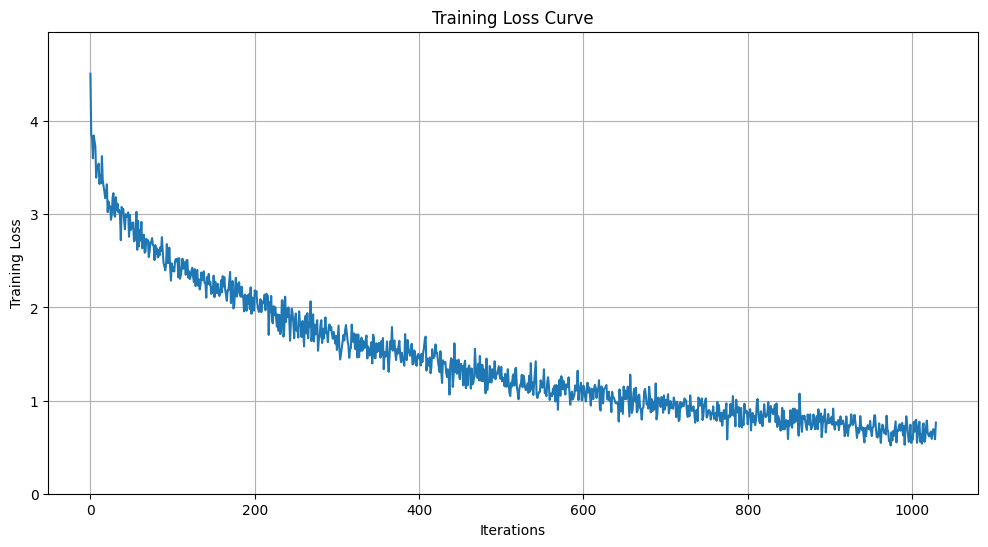

In [176]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task_5_losses = trainIters(encoder1, decoder1, 5, print_every=5000)

### Task 6 Loses

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 0/5
1m 37s (- 31m 47s) (5000 4%) 3.4784
3m 14s (- 30m 9s) (10000 9%) 3.2183
4m 50s (- 28m 25s) (15000 14%) 3.1602
6m 26s (- 26m 46s) (20000 19%) 3.1060
Epoch: 1/5
8m 3s (- 25m 10s) (25000 24%) 3.0370
9m 39s (- 23m 31s) (30000 29%) 3.0170
11m 16s (- 21m 55s) (35000 33%) 2.9789
12m 52s (- 20m 18s) (40000 38%) 2.9737
Epoch: 2/5
14m 29s (- 18m 41s) (45000 43%) 2.9009
16m 5s (- 17m 5s) (50000 48%) 2.8833
17m 41s (- 15m 28s) (55000 53%) 2.8555
19m 18s (- 13m 51s) (60000 58%) 2.8728
Epoch: 3/5
20m 55s (- 12m 15s) (65000 63%) 2.8382
22m 31s (- 10m 38s) (70000 67%) 2.8165
24m 8s (- 9m 2s) (75000 72%) 2.7912
25m 45s (- 7m 26s) (80000 77%) 2.8094
Epoch: 4/5
27m 23s (- 5m 49s) (85000 82%) 2.7809
29m 1s (- 4m 13s) (90000 87%) 2.7508
30m 40s (- 2m 36s) (95000 92%) 2.7316
32m 17s (- 0m 59s) (100000 97%) 2.7167


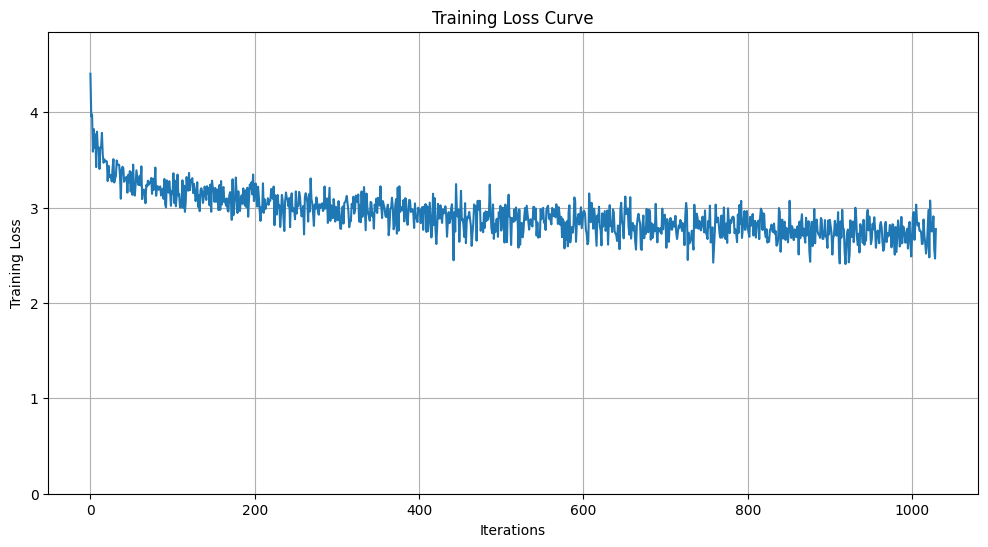

In [263]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

task_6_losses = trainIters(encoder1, decoder1, 5, print_every=5000)

### Evaluation Task 1

In [50]:
evaluateRandomly(encoder1, decoder1)

> je suis curieux .
= i m curious .
< i m curious . <EOS>

> je suis habitue a veiller tard .
= i am accustomed to staying up late .
< i m accustomed to staying up late . <EOS>

> j ai rencontre ton fils hier et il m a poliment saluee .
= i met your son yesterday and he greeted me politely .
< i met your son yesterday and he greeted me to . <EOS>

> je vais laisser tom repondre .
= i m going to let tom respond .
< i m going to leave tom . <EOS>

> je suis remue .
= i m shaken .
< i m an . <EOS>

> je ne vais rien y faire .
= i m not going to do anything about it .
< i m not going to do anything about it . <EOS>

> je ne suis pas doue pour l auto promotion .
= i m not good at self promotion .
< i m not good at keeping off . <EOS>

> il s habitue a cette situation .
= he s getting used to this situation .
< he s getting used to this situation . <EOS>

> je suis prete si vous l etes .
= i m ready if you are .
< i m ready if you are . <EOS>

> tu es en grand danger .
= you re in grave dang

In [51]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

100%|██████████| 20616/20616 [02:30<00:00, 136.97it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.80186695
Rouge1 precision:	 0.7496475
Rouge1 recall:  	 0.8688251
Rouge2 fmeasure:	 0.6855215
Rouge2 precision:	 0.6287777
Rouge2 recall:  	 0.7626308


In [52]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

100%|██████████| 2291/2291 [00:17<00:00, 130.39it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.6654205
Rouge1 precision:	 0.6258048
Rouge1 recall:  	 0.72006834
Rouge2 fmeasure:	 0.49286386
Rouge2 precision:	 0.45471483
Rouge2 recall:  	 0.5478828


### Evaluation - Task 3

In [121]:
evaluateRandomly(encoder1, decoder1)

> elle s inquiete pour ses examens .
= she s worrying about her exams .
< she is anxious about her by . 

> elle lui a fait un proces .
= she sued him .
< she sued him . 

> je suis sur de pouvoir le contacter par telephone .
= i am sure i can get in touch with him by telephone .
< i m sure i i get on the new . . 

> elle est toute differente de sa mere .
= she is not anything like her mother .
< she is her mother mother her mother . 

> elle aime prendre des photos .
= she s fond of taking pictures .
< she is fond of taking pictures . 

> vous etes deprime n est ce pas ?
= you re depressed aren t you ?
< you re depressed aren t you ? 

> vous etes innocent .
= you re innocent .
< you re innocent . 

> vous enfreignez la loi .
= you re breaking the law .
< you re breaking the law . 

> je suis trop fatigue pour etudier .
= i m too tired to do study .
< i m too tired to study . 

> je suis a la maison tout le temps .
= i m home all the time .
< i m at all time . 



In [122]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

100%|██████████| 20616/20616 [02:37<00:00, 130.49it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.808596
Rouge1 precision:	 0.82427144
Rouge1 recall:  	 0.798488
Rouge2 fmeasure:	 0.6642588
Rouge2 precision:	 0.67795914
Rouge2 recall:  	 0.6562831


In [123]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

100%|██████████| 2291/2291 [00:17<00:00, 130.43it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.7022564
Rouge1 precision:	 0.7203118
Rouge1 recall:  	 0.692405
Rouge2 fmeasure:	 0.51648027
Rouge2 precision:	 0.5311921
Rouge2 recall:  	 0.5095525


## Evaluation Task 4:

In [152]:
evaluateRandomly(encoder1, decoder1)

> nous n en sommes pas fiers .
= we re not proud of it .
< we re not proud of . 

> tu es incroyable .
= you re amazing .
< you re amazing . 

> je suis content que ca te rende heureuse .
= i m glad that makes you happy .
< i m glad that makes you happy happy . 

> tu es probablement fatigue .
= you re probably tired .
< you re probably tired . 

> nous sommes tous prets .
= we are all set .
< we re all set . 

> elle est encore mineure .
= she s still a minor .
< she is still a minor . 

> j y serai .
= i m going to be there .
< i m going to be there . 

> tu es incroyable .
= you re amazing .
< you re amazing . 

> je n en peux plus de me battre .
= i m sick of fighting .
< i m fighting of fighting . 

> je suis actuellement au travail .
= i m at work now .
< i m at work now . 



In [153]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

100%|██████████| 20616/20616 [02:43<00:00, 126.40it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.8744537
Rouge1 precision:	 0.8864969
Rouge1 recall:  	 0.86806524
Rouge2 fmeasure:	 0.7551044
Rouge2 precision:	 0.7658269
Rouge2 recall:  	 0.7503874


In [154]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

100%|██████████| 2291/2291 [00:17<00:00, 127.34it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.72604734
Rouge1 precision:	 0.74552596
Rouge1 recall:  	 0.7158071
Rouge2 fmeasure:	 0.540101
Rouge2 precision:	 0.5550995
Rouge2 recall:  	 0.53306854


## Evaluation Task 5:

In [219]:
evaluateRandomly(encoder1, decoder1)

> je ne suis pas normal .
= i m not normal .
< i   m   n o t   n o r m a l   .   < E O S >

> je suis fort modeste .
= i m very modest .
< i   m   v e r y   m o d e s t   .   < E O S >

> je suis encore membre .
= i m still a member .
< i   m   s t i l l   a   m e m b e r   .   < E O S >

> je suis sur que tom partira tot .
= i m sure tom will leave early .
< i   m   s u r e   t o m   w i l l   l e a v e   e a r l y   .   < E O S >

> tu es toujours avocate non ?
= you re still a lawyer aren t you ?
< y o u   r e   s t i l l   a   l a w y e r   a r e n   t   y o u   ?   < E O S >

> j ai bien peur que cette cle ne marche pas .
= i m afraid this key doesn t fit .
< i   m   a f r a i d   t h i s   i s n   t   t   .   < E O S >

> je ne dis pas que c est faux .
= i m not saying that s wrong .
< i   m   n o t   s a y i n g   t h a t   s   w r o n g   .   < E O S >

> elle semblait indifferente .
= she seemed uninterested .
< s h e   s e e m e d   u n i n t e r e s t e d   .   < E O S >

> 

In [220]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

  0%|          | 0/20616 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

## Evaluation Task 6

In [268]:
evaluateRandomly(encoder1, decoder1)

> vous etes matinal .
= you re early .
< i m not . . . . 

> je ne suis pas du genre a etaler mes histoires de fesses .
= i m not the kind to kiss and tell .
< i m not . . . . 

> tu ne pretes meme pas attention .
= you re not even paying attention .
< i m not . . . . 

> je suis plus intelligent que toi .
= i m smarter than you are .
< i m not . . . . 

> c est une tres chouette fille .
= she s a very nice girl .
< i m not . . . . 

> il a commence a apprendre l espagnol a la radio .
= he started to learn spanish from the radio .
< i m not . . . . 

> je ne suis pas photogenique .
= i m not photogenic .
< i m not . . . . 

> je sors cet apres midi .
= i m going out this afternoon .
< i m not . . . . 

> ils parlent de musique .
= they are talking about music .
< i m not . . . . 

> je ne suis pas la personne que je fus .
= i am not the person i used to be .
< i m not . . . . 



In [269]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

100%|██████████| 20616/20616 [05:18<00:00, 64.79it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.22710066
Rouge1 precision:	 0.34342256
Rouge1 recall:  	 0.17630842
Rouge2 fmeasure:	 0.13874087
Rouge2 precision:	 0.24211778
Rouge2 recall:  	 0.10252892


In [270]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

100%|██████████| 2291/2291 [00:35<00:00, 64.20it/s]


=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.23086245
Rouge1 precision:	 0.34730104
Rouge1 recall:  	 0.17930742
Rouge2 fmeasure:	 0.13953617
Rouge2 precision:	 0.24225229
Rouge2 recall:  	 0.10299744


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,8))
# plt.plot(task2_losses, label='Encoder-GRU, Decoder-GRU')
# plt.plot(task3_losses, label='Encoder-LSTM, Decoder-LSTM')
# plt.plot(task4_losses, label='Encoder-bi-LSTM, Decoder-GRU')
# plt.plot(task5_losses, label='Encoder-GRU, Decoder-GRU, Attention Mechanism')
# plt.plot(task6_losses, label='Encoder-Transformer, Decoder-GRU')
# plt.ylim((0,4))
# plt.xlabel('Iterations (thousands)')
# plt.ylabel('Training Loss')
# plt.legend()

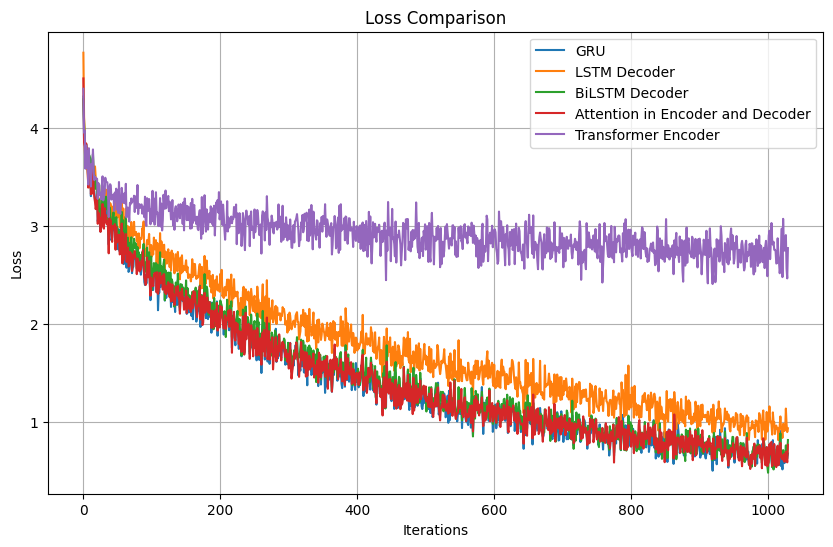

In [273]:
import matplotlib.pyplot as plt

def plot_losses(loss_values, legends):
    plt.figure(figsize=(10, 6))
    for loss, legend in zip(loss_values, legends):
        plt.plot(loss, label=legend)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

loss_values = [task_2_losses, task_3_losses, task_4_losses, task_5_losses, task_6_losses]
legends = ["GRU", "LSTM Decoder", "BiLSTM Decoder", "Attention in Encoder and Decoder", "Transformer Encoder"]

plot_losses(loss_values, legends)